## Mixed linear model to model HTO single-cell macrophage data for 9 different conditions
## Fan Zhang
## 2020-05-18

In [2]:
suppressMessages({
library(magrittr)
library(dplyr)
library(Matrix)
library(ggplot2)
library(ggthemes)
# library(DropletUtils)
library(data.table)
library(harmony)
library(ggrepel)
library(presto)
library(gridExtra)
library(RcppCNPy)
library(stringr)
library(viridis)
library(nlme)
library(limma)
library(glmnet)
# library(factoextra)
})

library(RColorBrewer)
library(fractional)
effect_x <- "t6"
effect_y <- "d10"

cat_colors <- brewer.pal(n = 5, name = "Set2")
# cat_colors <- scico::scico(n = 5, palette = "roma")
cat_alpha  <- 0.7

In [3]:
# Functions
FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

### We want to fit a linear model with condition factor to expression of each gene in order to find sets of genes associated with each stimulation

In [4]:
# Load normalized scRNA-seq
data <- readRDS("qc_mRNA_exprs_norm_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_2020-04-15.rds")
meta <- readRDS("qc_meta_all_cluster_trajectory_nGene1200_MT0.1_umap_max.ab.UMIs_0.90_ab.rat_0.10_cell_use_correctlabel_2020-05-11.rds")
dim(data)
all(colnames(data) == meta$cell)

[1] 33538 25823

[1] TRUE

In [5]:
# Find varible genes
exprs_norm <- data
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(exprs_norm), value = TRUE)
genes_use <- setdiff(row.names(data), genes_exclude)

# vargenes_df <- FindVariableGenesBatch(exprs_norm, meta, genes_exclude, 1e3)
vargenes_df <- FindVariableGenesSeurat(data[genes_use,]) %>% 
            subset(gene.mean >= 0.1) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion)
nrow(vargenes_df)
# table(vargenes_df$N)
var_genes <- vargenes_df$gene[1:7000]
length(var_genes)

[1] 7175

[1] 7000

In [6]:
meta[1:4, c("sample", "nUMI", "stim")]

,sample,nUMI,stim
5,sample_1,8934,Control
16,sample_1,11496,TNFa+ fibro+
17,sample_1,16231,Control
21,sample_1,10483,IFNg+ fibro+


## linear modeling 

In [7]:
des2 <- with(meta, model.matrix(~ stim + stim*(stim-1) + nUMI + sample)) # Control and all 8 conditions, no intercept
# des <- with(meta, model.matrix(~ 0 + stim + nUMI + sample)) # global intercept without control
colnames(des2) <- str_replace_all(colnames(des2), ":", "_")
dim(des2)
# des2[1:4,]

fit2 <- lmFit(exprs_norm[var_genes,], des2)
fit2 <- eBayes(fit2)
fit2$genes <- rownames(fit2$coefficients)

dim(fit2)
# colnames(fit2$coefficients)

[1] 25823    13

[1] 7000   13

In [8]:
# logFC: log2 fold change 
# AveExpr: Average expression, in log2 counts per million
# t: t-statistic, i.e. logFC divided by its standard error
# P.Value: Raw p-value from test that logFC differs from 0
# adj.P.Val: Benjamini-Hochberg false discovery rate adjusted p-value

In [9]:
# Test results of CXCL9

dat_stim <- topTable(fit2, coef = "stimTNFa+ fibro+", number = 1e6)
dat_stim <- dat_stim[order(rownames(dat_stim)),]
dat_stim$coef <- "TNFa+ fibro+"
test <- dat_stim[order(dat_stim$logFC, decreasing = T),]
# test[1:10,]
dat_stim[which(rownames(dat_stim) == "CXCL9"),]

dat_stim <- topTable(fit2, coef = "stimTNFa+ IFNg+ fibro+", number = 1e6)
dat_stim <- dat_stim[order(rownames(dat_stim)),]
dat_stim$coef <- "stimTNFa+ IFNg+ fibro+"
test <- dat_stim[order(dat_stim$logFC, decreasing = T),]
# test[1:10,]
dat_stim[which(rownames(dat_stim) == "CXCL9"),]


dat_stim <- topTable(fit2, coef = "stimTNFa+ IFNg+", number = 1e6)
dat_stim <- dat_stim[order(rownames(dat_stim)),]
dat_stim$coef <- "stimTNFa+ IFNg+"
test <- dat_stim[order(dat_stim$logFC, decreasing = T),]
# test[1:10,]
dat_stim[which(rownames(dat_stim) == "CXCL9"),]


dat_stim <- topTable(fit2, coef = "stimIFNg+ fibro+", number = 1e6)
dat_stim <- dat_stim[order(rownames(dat_stim)),]
dat_stim$coef <- "stimIFNg+ fibro+"
test <- dat_stim[order(dat_stim$logFC, decreasing = T),]
# test[1:10,]
dat_stim[which(rownames(dat_stim) == "CXCL9"),]

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,coef
CXCL9,CXCL9,0.1003722,1.567176,3.47645,0.0005089343,0.0005240571,-3.988476,TNFa+ fibro+


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,coef
CXCL9,CXCL9,2.378002,1.567176,74.69919,0,0,2515.99,stimTNFa+ IFNg+ fibro+


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,coef
CXCL9,CXCL9,2.623355,1.567176,97.11938,0,0,4009.774,stimTNFa+ IFNg+


,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B,coef
CXCL9,CXCL9,2.176788,1.567176,67.94219,0,0,2113.498,stimIFNg+ fibro+


In [10]:
# Combind results
dat_control <- topTable(fit2, coef = "stimControl", number = 1e6)
dat_control <- dat_control[order(rownames(dat_control)),]
dat_control$coef <- "Control"


dat_tnf_fib <- topTable(fit2, coef = "stimTNFa+ fibro+", number = 1e6)
dat_tnf_fib <- dat_tnf_fib[order(rownames(dat_tnf_fib)),]
dat_tnf_fib$coef <- "TNFa+ fibro+"

dat_tnf_ifg_fib <- topTable(fit2, coef = "stimTNFa+ IFNg+ fibro+", number = 1e6)
dat_tnf_ifg_fib <- dat_tnf_ifg_fib[order(rownames(dat_tnf_ifg_fib)),]
dat_tnf_ifg_fib$coef <- "TNFa+ IFNg+ fibro+"

dat_tnf_ifg <- topTable(fit2, coef = "stimTNFa+ IFNg+", number = 1e6)
dat_tnf_ifg <- dat_tnf_ifg[order(rownames(dat_tnf_ifg)),]
dat_tnf_ifg$coef <- "TNFa+ fibro+"

dat_tnf <- topTable(fit2, coef = "stimTNFa+", number = 1e6)
dat_tnf <- dat_tnf[order(rownames(dat_tnf)),]
dat_tnf$coef <- "TNFa+"

dat_il4 <- topTable(fit2, coef = "stimIL4+", number = 1e6)
dat_il4 <- dat_il4[order(rownames(dat_il4)),]
dat_il4$coef <- "IL4"

dat_ifg_fib <- topTable(fit2, coef = "stimIFNg+ fibro+", number = 1e6)
dat_ifg_fib <- dat_ifg_fib[order(rownames(dat_ifg_fib)),]
dat_ifg_fib$coef <- "IFNg+ fibro+"

dat_ifg <- topTable(fit2, coef = "stimIFNg+", number = 1e6)
dat_ifg <- dat_ifg[order(rownames(dat_ifg)),]
dat_ifg$coef <- "IFNg+"

dat_ifb <- topTable(fit2, coef = "stimIFNb+", number = 1e6)
dat_ifb <- dat_ifb[order(rownames(dat_ifb)),]
dat_ifb$coef <- "IFNb+"


stopifnot(all(rownames(dat_tnf_fib) == rownames(dat_tnf_ifg_fib)))

dat2 <- data.frame(
    Gene     = dat_control$ID,
    lgfc_tnf_fib      = dat_tnf_fib$logFC,
    lgfc_tnf_ifg_fib = dat_tnf_ifg_fib$logFC,
    lgfc_tnf_ifg  = dat_tnf_ifg$logFC,
    lgfc_tnf  =  dat_tnf$logFC,
    lgfc_il4  =  dat_il4$logFC,
    lgfc_ifg_fib  =  dat_ifg_fib$logFC,
    lgfc_ifg  =  dat_ifg$logFC,
    lgfc_ifb  =  dat_ifb$logFC,
    lgfc_control = dat_control$logFC,
    
    p_tnf_fib      = dat_tnf_fib$P.Value,
    p_tnf_ifg_fib = dat_tnf_ifg_fib$P.Value,
    p_tnf_ifg  = dat_tnf_ifg$P.Value,
    p_tnf  = dat_tnf$P.Value,
    p_il4  =  dat_il4$P.Value,
    p_ifg_fib  =  dat_ifg_fib$P.Value,
    p_ifg  =  dat_ifg$P.Value,
    p_ifb  =  dat_ifb$P.Value,
    p_control = dat_control$P.Value,
    
    adjP_tnf_fib      = dat_tnf_fib$adj.P.Val,
    adjP_tnf_ifg_fib = dat_tnf_ifg_fib$adj.P.Val,
    adjP_tnf_ifg  = dat_tnf_ifg$adj.P.Val,
    adjP_tnf  = dat_tnf$adj.P.Val,
    adjP_il4  =  dat_il4$adj.P.Val,
    adjP_ifg_fib  =  dat_ifg_fib$adj.P.Val,
    adjP_ifg  =  dat_ifg$adj.P.Val,
    adjP_ifb  =  dat_ifb$adj.P.Val,
    adjP_control = dat_control$adj.P.Val,
    
    t_tnf_fib      = dat_tnf_fib$t,
    t_tnf_ifg_fib = dat_tnf_ifg_fib$t,
    t_tnf_ifg  = dat_tnf_ifg$t,
    t_tnf  = dat_tnf$t,
    t_il4  =  dat_il4$t,
    t_ifg_fib  =  dat_ifg_fib$t,
    t_ifg  =  dat_ifg$t,
    t_ifb  =  dat_ifb$t,
    t_control = dat_control$t
    
)
# dat$signif <- abs(dat$dat_tnf_fib) > log2(2) | abs(dat$dat_tnf_ifg_fib) > log2(2)
head(dat2)

Gene,lgfc_tnf_fib,lgfc_tnf_ifg_fib,lgfc_tnf_ifg,lgfc_tnf,lgfc_il4,lgfc_ifg_fib,lgfc_ifg,lgfc_ifb,lgfc_control,...,adjP_control,t_tnf_fib,t_tnf_ifg_fib,t_tnf_ifg,t_tnf,t_il4,t_ifg_fib,t_ifg,t_ifb,t_control
A1BG,0.19837866,0.08587751,0.08145840,0.17336941,0.15197593,0.08907688,0.07919988,0.11387606,0.21187221,...,7.106536e-188,24.447350,9.598362,10.729976,16.070555,16.699967,9.892418,9.384174,12.254044,29.52919
AAED1,0.06292624,0.14720562,0.14577484,0.08471506,0.16593868,0.17056945,0.14073134,0.10624110,0.11176375,...,4.953794e-30,5.685103,12.061790,14.077162,5.756900,13.367744,13.886998,12.224526,8.381259,11.41953
AAGAB,0.05112525,0.07340191,0.06521466,0.05723744,0.05944515,0.08596600,0.06962011,0.09852758,0.06458765,...,3.048211e-24,7.127266,9.280594,9.717594,6.001907,7.389378,10.799778,9.331616,11.993763,10.18305
AAK1,0.40224706,0.34352622,0.30893087,0.34056138,0.32001784,0.38919666,0.32460422,0.32951512,0.37230737,...,1.378408e-188,28.264797,21.892419,23.202795,17.999894,20.050774,24.644653,21.930161,20.218014,29.58662
AAMDC,0.10067891,0.08552755,0.09954865,0.11954349,0.07184934,0.11748126,0.15383321,0.14666601,0.12636278,...,7.970957e-53,10.825189,8.340343,11.440853,9.668175,6.888485,11.383248,15.903100,13.770085,15.36586
AAMP,0.16322284,0.17759022,0.19355009,0.14056345,0.21859374,0.21355418,0.21944886,0.12612290,0.16354713,...,3.460841e-63,14.881011,14.684238,18.861268,9.639299,17.770235,17.545275,19.236209,10.040506,16.86301


In [11]:
# saveRDS(dat2, "mac_stimuli_linear_model.rds")


FALSE  TRUE 
 6497   503 

[1] 32

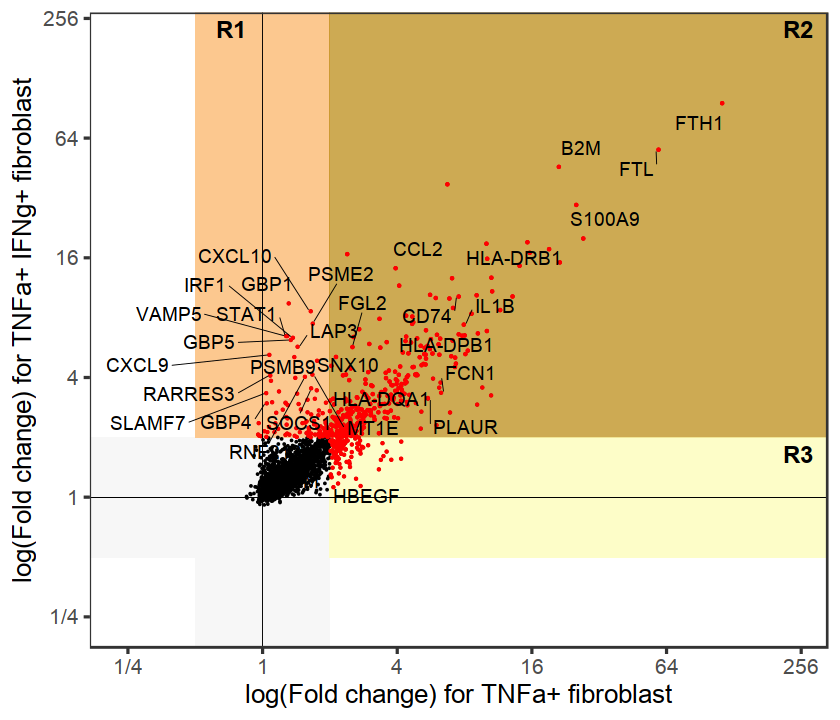

In [15]:
# Visualize the significant genens that greater than log2(2)

dat2$signif <- abs(dat2$lgfc_tnf_fib) > log2(2) | abs(dat2$lgfc_tnf_ifg_fib) > log2(2)
table(dat2$signif)

temp <- dat2[which(abs(dat2$lgfc_tnf_ifg_fib) > log2(4) & abs(dat2$lgfc_tnf_fib) < log2(2)),]
gene_plot <- as.character(temp$Gene)
# temp <- dat2[which(dat2$lgfc_tnf_fib > log2(2)), ]
# gene_plot <- c(gene_plot, as.character(temp$Gene))
gene_plot <- c(gene_plot, c("CREM", "CCL2", "IRF1", "SLAMF7", "SOCS1", "IL1B", "HBEGF", "PLAUR", "FTL", "FTH1", "S100A9", "B2M",
                            "SNX10", "HLA-DRB1", "CD74", "HLA-DPB1", "HLA-DQA1", "GBP4", "FGL2", "FCN1"))
gene_plot <- unique(gene_plot)
length(gene_plot)

options(repr.plot.width = 7, repr.plot.height = 6)

# dat2 %>% lmFit(signif) %>%
dat2 %>%
ggplot(aes(x = lgfc_tnf_fib, y = lgfc_tnf_ifg_fib)) +
annotate(
  geom = "rect",
  fill = "grey97",
  xmin = -Inf, xmax = Inf, ymin = -log2(2), ymax = log2(2)
) +
annotate(
  geom = "rect",
  fill = "grey97",
  ymin = -Inf, ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill =  "#FDB462", # cat_colors[1],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = "darkgoldenrod", # cat_colors[1],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = log2(2), xmax = Inf
) +
annotate(
  geom = "rect",
  fill = "#FFFFB3", # cat_colors[4],
  alpha = cat_alpha, color = NA,
  ymin = -log2(2), ymax = log2(2), xmin = log2(2), xmax = Inf
) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[3],
#   alpha = cat_alpha, color = NA,
#   ymin = -Inf, ymax = -log2(2), xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[5],
#   alpha = cat_alpha, color = NA,
#   ymin = -log2(2), ymax = log2(2), xmin = -Inf, xmax = -log2(2)
# ) +
annotate(
  geom = "text", color = "black", label = "R1",
  y = Inf, x = -log(2), hjust = 0, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "R2",
  y = Inf, x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "R3",
  y = log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
# annotate(
#   geom = "text", color = "black", label = "C4",
#   y = -log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
# ) +
# annotate(
#   geom = "text", color = "black", label = "C5",
#   y = log2(2), x = -Inf, hjust = -0.9, vjust = 1.5, size = 6, fontface = "bold"
# ) +
geom_point(
  data = dat2,
  mapping = aes(x = lgfc_tnf_fib, y = lgfc_tnf_ifg_fib),
  size = 0.01
) +
geom_point(
  data = subset(dat2, lgfc_tnf_ifg_fib > log2(2) & abs(lgfc_tnf_fib) < log2(4)),
  mapping = aes(x = lgfc_tnf_fib, y = lgfc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_point(
  data = subset(dat2, (lgfc_tnf_fib) > log2(2)),
  mapping = aes(x = lgfc_tnf_fib, y = lgfc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
# geom_text_repel(
#   data =subset(dat, abs(fc_tnf_ifg_fib) > log2(4) & abs(fc_tnf_fib) < log2(2)),
#   mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.2, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
# geom_text_repel(
#   data =subset(dat, fc_tnf_fib > log2(2)),
#   mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.2, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
geom_point(
  data = subset(dat2, abs(lgfc_tnf_ifg_fib) > 2 & abs(lgfc_tnf_fib) > 2),
  mapping = aes(x = lgfc_tnf_fib, y = lgfc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_text_repel(
  data =dat2[which(dat2$Gene %in% gene_plot),], 
  mapping = aes(x = lgfc_tnf_fib, y = lgfc_tnf_ifg_fib, label = Gene),
  box.padding = unit(0.3, "lines"),
  point.padding = unit(0.2, "lines"),
  segment.size = 0.2
) +
scale_color_manual(values = c("grey70", "black")) +
scale_y_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(6)) +
scale_x_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(4)) +
theme(legend.position = "none") +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
labs(x = "log(Fold change) for TNFa+ fibroblast", y = "log(Fold change) for TNFa+ IFNg+ fibroblast"
#      title = "Human blood-derived macropahge phenotypes"
    ) +
theme_bw(base_size = 15) +
theme(
#     legend.position = "none",
    axis.line = element_blank(),
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15)
  ) 
ggsave(file = paste("linear_model_plot1", ".png", sep = ""), width = 7, height = 5, dpi = 300)


FALSE  TRUE 
 6929    71 

[1] 28

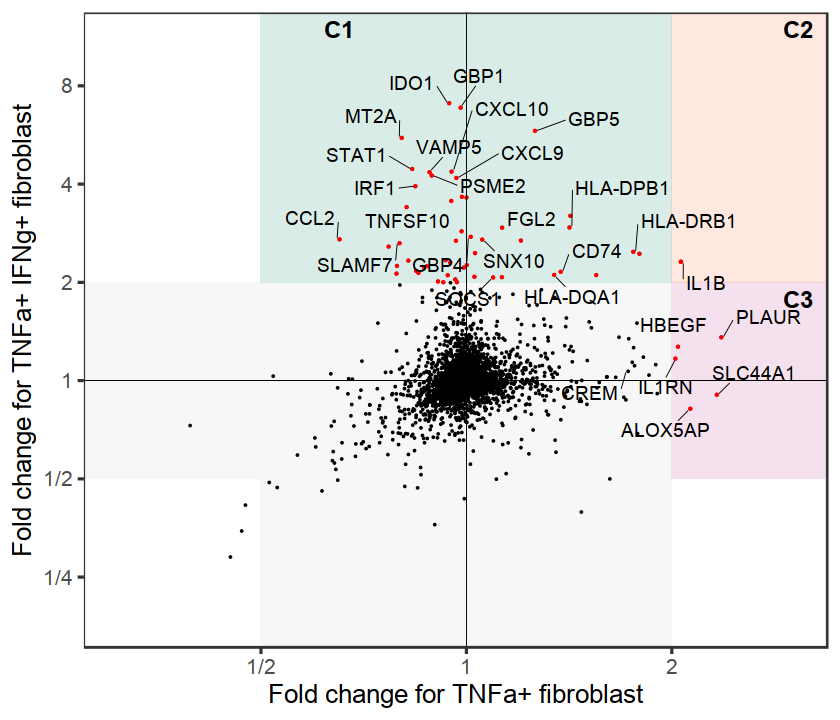

In [188]:
dat$signif <- abs(dat$fc_tnf_fib) > log2(2) | abs(dat$fc_tnf_ifg_fib) > log2(2)
table(dat$signif)

temp <- dat[which(abs(dat$fc_tnf_ifg_fib) > log2(4) & abs(dat$fc_tnf_fib) < log2(2)),]
gene_plot <- as.character(temp$Gene)
temp <- dat[which(dat$fc_tnf_fib > log2(2)), ]
gene_plot <- c(gene_plot, as.character(temp$Gene))
gene_plot <- c(gene_plot, c("CREM", "CCL2", "IRF1", "TNFSF10", "SLAMF7", "SOCS1", "SNX10", "HLA-DRB1", "CD74", "HLA-DPB1", "HLA-DQA1", "GBP4", "FGL2"))
gene_plot <- unique(gene_plot)
length(gene_plot)

options(repr.plot.width = 7, repr.plot.height = 6)

# dat %>% lmFit(signif) %>%
dat %>%
ggplot(aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib)) +
annotate(
  geom = "rect",
  fill = "grey97",
  xmin = -Inf, xmax = Inf, ymin = -log2(2), ymax = log2(2)
) +
annotate(
  geom = "rect",
  fill = "grey97",
  ymin = -Inf, ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[1],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[2],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = log2(2), xmax = Inf
) +
annotate(
  geom = "rect",
  fill = cat_colors[4],
  alpha = cat_alpha, color = NA,
  ymin = -log2(2), ymax = log2(2), xmin = log2(2), xmax = Inf
) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[3],
#   alpha = cat_alpha, color = NA,
#   ymin = -Inf, ymax = -log2(2), xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[5],
#   alpha = cat_alpha, color = NA,
#   ymin = -log2(2), ymax = log2(2), xmin = -Inf, xmax = -log2(2)
# ) +
annotate(
  geom = "text", color = "black", label = "C1",
  y = Inf, x = -log(2), hjust = 0, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C2",
  y = Inf, x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C3",
  y = log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
# annotate(
#   geom = "text", color = "black", label = "C4",
#   y = -log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
# ) +
# annotate(
#   geom = "text", color = "black", label = "C5",
#   y = log2(2), x = -Inf, hjust = -0.9, vjust = 1.5, size = 6, fontface = "bold"
# ) +
geom_point(
  data = dat,
  mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib),
  size = 0.01
) +
geom_point(
  data = subset(dat, fc_tnf_ifg_fib > log2(2) & abs(fc_tnf_fib) < log2(4)),
  mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_point(
  data = subset(dat, (fc_tnf_fib) > log2(2)),
  mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
# geom_text_repel(
#   data =subset(dat, abs(fc_tnf_ifg_fib) > log2(4) & abs(fc_tnf_fib) < log2(2)),
#   mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.2, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
# geom_text_repel(
#   data =subset(dat, fc_tnf_fib > log2(2)),
#   mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.2, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
geom_text_repel(
  data =dat[which(dat$Gene %in% gene_plot),],  # "FCN1", "SPP1"
  mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib, label = Gene),
  box.padding = unit(0.4, "lines"),
  point.padding = unit(0.2, "lines"),
  segment.size = 0.2
) +
geom_point(
  data = subset(dat, abs(fc_tnf_ifg_fib) > 2 & abs(fc_tnf_fib) > 2),
  mapping = aes(x = fc_tnf_fib, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
scale_color_manual(values = c("grey70", "black")) +
scale_y_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(6)) +
scale_x_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(4)) +
theme(legend.position = "none") +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
labs(x = "Fold change for TNFa+ fibroblast", y = "Fold change for TNFa+ IFNg+ fibroblast"
#      title = "Human blood-derived macropahge phenotypes"
    ) +
theme_bw(base_size = 15) +
theme(
#     legend.position = "none",
    axis.line = element_blank(),
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15)
  ) 
ggsave(file = paste("linear_model_plot2", ".pdf", sep = ""), width = 7, height = 6, dpi = 300)


FALSE  TRUE 
 6924    76 

[1] 5

[1] 15

[1] 22

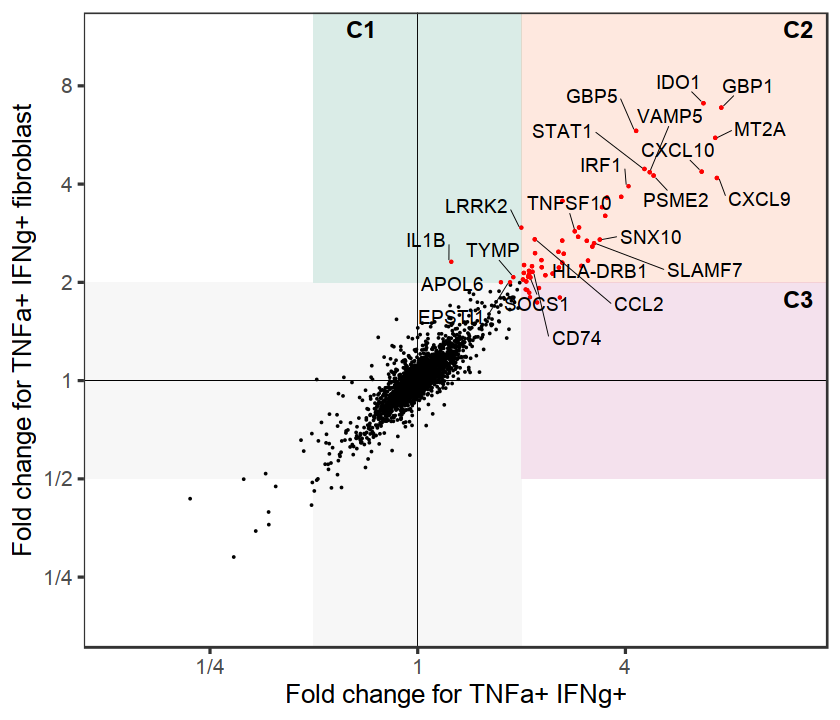

In [186]:
dat$signif <- abs(dat$fc_tnf_ifg) > log2(2) | abs(dat$fc_tnf_ifg_fib) > log2(2)
table(dat$signif)

temp <- dat[which(dat$fc_tnf_ifg_fib > log2(2) & abs(dat$fc_tnf_ifg) < log2(2)),]
gene_plot <- as.character(temp$Gene)
length(gene_plot)
temp <- dat[which(dat$fc_tnf_ifg > log2(4)),]
gene_plot <- c(gene_plot, as.character(temp$Gene))
length(gene_plot)
gene_plot <- c(gene_plot, c("CCL2", "IRF1", "TNFSF10", "SLAMF7", "SOCS1", "SNX10", "HLA-DRB1", "CD74"))
gene_plot <- unique(gene_plot)
length(gene_plot)

options(repr.plot.width = 7, repr.plot.height = 6)

# dat %>% lmFit(signif) %>%
dat %>%
ggplot(aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib)) +
annotate(
  geom = "rect",
  fill = "grey97",
  xmin = -Inf, xmax = Inf, ymin = -log2(2), ymax = log2(2)
) +
annotate(
  geom = "rect",
  fill = "grey97",
  ymin = -Inf, ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[1],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[2],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = log2(2), xmax = Inf
) +
annotate(
  geom = "rect",
  fill = cat_colors[4],
  alpha = cat_alpha, color = NA,
  ymin = -log2(2), ymax = log2(2), xmin = log2(2), xmax = Inf
) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[3],
#   alpha = cat_alpha, color = NA,
#   ymin = -Inf, ymax = -log2(2), xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[5],
#   alpha = cat_alpha, color = NA,
#   ymin = -log2(2), ymax = log2(2), xmin = -Inf, xmax = -log2(2)
# ) +
annotate(
  geom = "text", color = "black", label = "C1",
  y = Inf, x = -log(2), hjust = 0, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C2",
  y = Inf, x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C3",
  y = log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
# annotate(
#   geom = "text", color = "black", label = "C4",
#   y = -log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
# ) +
# annotate(
#   geom = "text", color = "black", label = "C5",
#   y = log2(2), x = -Inf, hjust = -0.9, vjust = 1.5, size = 6, fontface = "bold"
# ) +
geom_point(
  data = dat,
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib),
  size = 0.01
) +
geom_point(
  data = subset(dat, fc_tnf_ifg_fib > log2(2) & abs(fc_tnf_ifg) < log2(4)),
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_point(
  data = subset(dat, (fc_tnf_ifg) > log2(2)),
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
# geom_text_repel(
#   data =subset(dat, (fc_tnf_ifg_fib) > log2(2) & abs(fc_tnf_ifg) < log2(2)),
#   mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.4, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
# geom_text_repel(
#   data =subset(dat, fc_tnf_ifg > log2(4)),
#   mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.2, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
geom_point(
  data = subset(dat, abs(fc_tnf_ifg_fib) > 2 & abs(fc_tnf_ifg) > 2),
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_text_repel(
  data =dat[which(dat$Gene %in% gene_plot),],  # "FCN1", "SPP1"
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
  box.padding = unit(0.4, "lines"),
  point.padding = unit(0.2, "lines"),
  segment.size = 0.2
) +
scale_color_manual(values = c("grey70", "black")) +
scale_y_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(6)) +
scale_x_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(4)) +
theme(legend.position = "none") +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
labs(x = "Fold change for TNFa+ IFNg+", y = "Fold change for TNFa+ IFNg+ fibroblast"
#      title = "Human blood-derived macropahge phenotypes"
    ) +
theme_bw(base_size = 15) +
theme(
#     legend.position = "none",
    axis.line = element_blank(),
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15)
  ) 
                   
ggsave(file = paste("linear_model_plot1", ".pdf", sep = ""), width = 7, height = 6, dpi = 300)


FALSE  TRUE 
 6922    78 

[1] 14

[1] 26

[1] 34

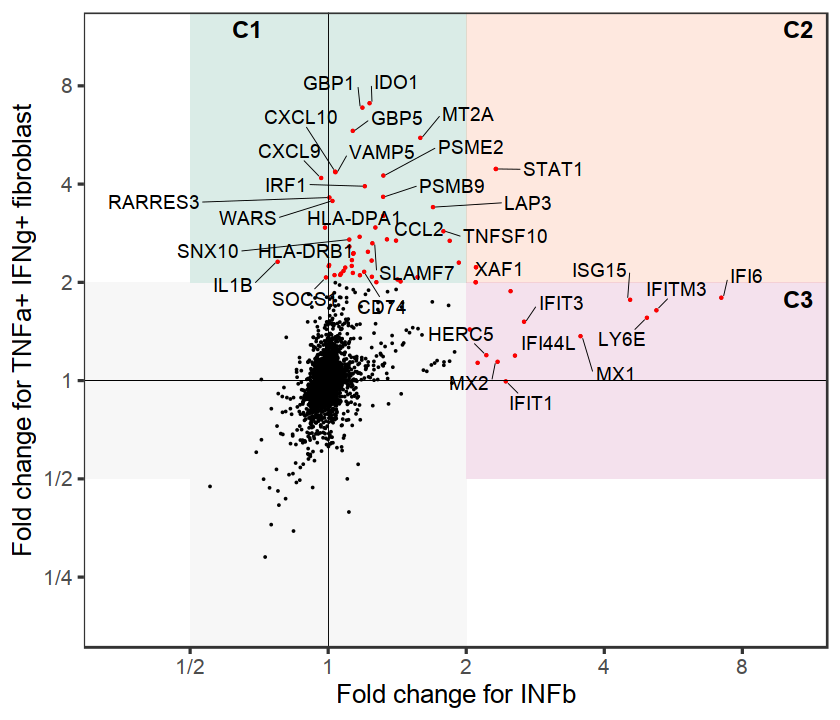

In [201]:
dat$signif <- abs(dat$fc_ifb) > log2(2) | abs(dat$fc_tnf_ifg_fib) > log2(2)
table(dat$signif)

temp <- dat[which(dat$fc_tnf_ifg_fib > log2(3) & abs(dat$fc_ifb) < log2(2)),]
gene_plot <- as.character(temp$Gene)
length(gene_plot)
temp <- dat[which(dat$fc_ifb > log2(2.2)),]
gene_plot <- c(gene_plot, as.character(temp$Gene))
length(gene_plot)
gene_plot <- c(gene_plot, c("CCL2", "IRF1", "TNFSF10", "SLAMF7", "SOCS1", "SNX10", "HLA-DRB1", "CD74", "IL1B"))
gene_plot <- unique(gene_plot)
length(gene_plot)

options(repr.plot.width = 7, repr.plot.height = 6)

# dat %>% lmFit(signif) %>%
dat %>%
ggplot(aes(x = fc_ifb, y = fc_tnf_ifg_fib)) +
annotate(
  geom = "rect",
  fill = "grey97",
  xmin = -Inf, xmax = Inf, ymin = -log2(2), ymax = log2(2)
) +
annotate(
  geom = "rect",
  fill = "grey97",
  ymin = -Inf, ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[1],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[2],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = log2(2), xmax = Inf
) +
annotate(
  geom = "rect",
  fill = cat_colors[4],
  alpha = cat_alpha, color = NA,
  ymin = -log2(2), ymax = log2(2), xmin = log2(2), xmax = Inf
) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[3],
#   alpha = cat_alpha, color = NA,
#   ymin = -Inf, ymax = -log2(2), xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[5],
#   alpha = cat_alpha, color = NA,
#   ymin = -log2(2), ymax = log2(2), xmin = -Inf, xmax = -log2(2)
# ) +
annotate(
  geom = "text", color = "black", label = "C1",
  y = Inf, x = -log(2), hjust = 0, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C2",
  y = Inf, x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C3",
  y = log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
# annotate(
#   geom = "text", color = "black", label = "C4",
#   y = -log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
# ) +
# annotate(
#   geom = "text", color = "black", label = "C5",
#   y = log2(2), x = -Inf, hjust = -0.9, vjust = 1.5, size = 6, fontface = "bold"
# ) +
geom_point(
  data = dat,
  mapping = aes(x = fc_ifb, y = fc_tnf_ifg_fib),
  size = 0.01
) +
geom_point(
  data = subset(dat, fc_tnf_ifg_fib > log2(2) & abs(fc_ifb) < log2(4)),
  mapping = aes(x = fc_ifb, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_point(
  data = subset(dat, (fc_ifb) > log2(2)),
  mapping = aes(x = fc_ifb, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
# geom_text_repel(
#   data =subset(dat, (fc_tnf_ifg_fib) > log2(2) & abs(fc_tnf_ifg) < log2(2)),
#   mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.4, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
# geom_text_repel(
#   data =subset(dat, fc_tnf_ifg > log2(4)),
#   mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.2, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
geom_point(
  data = subset(dat, abs(fc_tnf_ifg_fib) > 2 & abs(fc_ifb) > 2),
  mapping = aes(x = fc_ifb, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_text_repel(
  data =dat[which(dat$Gene %in% gene_plot),],  # "FCN1", "SPP1"
  mapping = aes(x = fc_ifb, y = fc_tnf_ifg_fib, label = Gene),
  box.padding = unit(0.4, "lines"),
  point.padding = unit(0.2, "lines"),
  segment.size = 0.2
) +
scale_color_manual(values = c("grey70", "black")) +
scale_y_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(6)) +
scale_x_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(4)) +
theme(legend.position = "none") +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
labs(x = "Fold change for INFb", y = "Fold change for TNFa+ IFNg+ fibroblast"
#      title = "Human blood-derived macropahge phenotypes"
    ) +
theme_bw(base_size = 15) +
theme(
#     legend.position = "none",
    axis.line = element_blank(),
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15)
  ) 
                   
ggsave(file = paste("linear_model_plot4", ".pdf", sep = ""), width = 7, height = 6, dpi = 300)


FALSE  TRUE 
 6905    95 

[1] 14

[1] 25

[1] 33

[1] 33

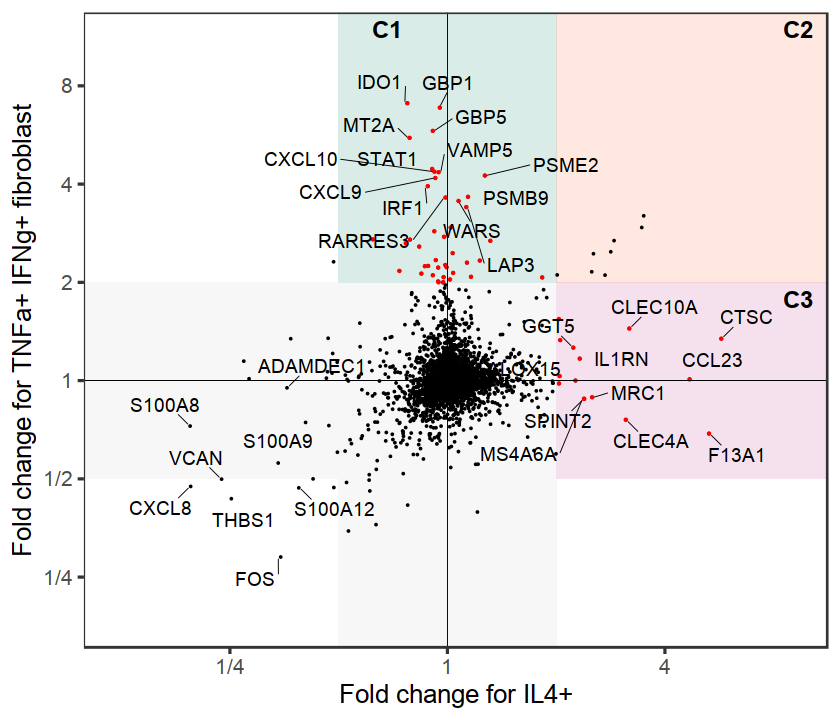

In [217]:
dat$signif <- abs(dat$dfc_il4) > log2(2) | abs(dat$fc_tnf_ifg_fib) > log2(2)
table(dat$signif)

temp <- dat[which(dat$fc_tnf_ifg_fib > log2(3) & abs(dat$dfc_il4) < log2(2)),]
gene_plot <- as.character(temp$Gene)
length(gene_plot)
temp <- dat[which(dat$dfc_il4 > log2(2.2) & dat$fc_tnf_ifg_fib < log2(2)),]
gene_plot <- c(gene_plot, as.character(temp$Gene))
length(gene_plot)
temp <- dat[which(dat$dfc_il4 < log2(1/2.5) & dat$fc_tnf_ifg_fib < log2(1)),]
gene_plot <- c(gene_plot, as.character(temp$Gene))
length(gene_plot)

# gene_plot <- c(gene_plot, c("CCL2", "IRF1", "TNFSF10", "SLAMF7", "SOCS1", "SNX10", "HLA-DRB1", "CD74", "IL1B",
#                            "CTSC"))
gene_plot <- unique(gene_plot)
length(gene_plot)

options(repr.plot.width = 7, repr.plot.height = 6)

# dat %>% lmFit(signif) %>%
dat %>%
ggplot(aes(x = dfc_il4, y = fc_tnf_ifg_fib)) +
annotate(
  geom = "rect",
  fill = "grey97",
  xmin = -Inf, xmax = Inf, ymin = -log2(2), ymax = log2(2)
) +
annotate(
  geom = "rect",
  fill = "grey97",
  ymin = -Inf, ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[1],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[2],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = log2(2), xmax = Inf
) +
annotate(
  geom = "rect",
  fill = cat_colors[4],
  alpha = cat_alpha, color = NA,
  ymin = -log2(2), ymax = log2(2), xmin = log2(2), xmax = Inf
) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[3],
#   alpha = cat_alpha, color = NA,
#   ymin = -Inf, ymax = -log2(2), xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[5],
#   alpha = cat_alpha, color = NA,
#   ymin = -log2(2), ymax = log2(2), xmin = -Inf, xmax = -log2(2)
# ) +
annotate(
  geom = "text", color = "black", label = "C1",
  y = Inf, x = -log(2), hjust = 0, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C2",
  y = Inf, x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C3",
  y = log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
# annotate(
#   geom = "text", color = "black", label = "C4",
#   y = -log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
# ) +
# annotate(
#   geom = "text", color = "black", label = "C5",
#   y = log2(2), x = -Inf, hjust = -0.9, vjust = 1.5, size = 6, fontface = "bold"
# ) +
geom_point(
  data = dat,
  mapping = aes(x = dfc_il4, y = fc_tnf_ifg_fib),
  size = 0.01
) +
geom_point(
  data = subset(dat, fc_tnf_ifg_fib > log2(2) & abs(dfc_il4) < log2(2)),
  mapping = aes(x = dfc_il4, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_point(
  data = subset(dat, (dfc_il4) > log2(2) & fc_tnf_ifg_fib < log2(2)),
  mapping = aes(x = dfc_il4, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
# geom_text_repel(
#   data =subset(dat, (fc_tnf_ifg_fib) > log2(2) & abs(fc_tnf_ifg) < log2(2)),
#   mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.4, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
# geom_text_repel(
#   data =subset(dat, fc_tnf_ifg > log2(4)),
#   mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.2, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
# geom_point(
#   data = subset(dat, abs(fc_tnf_ifg_fib) > 2 & abs(dfc_il4) > 2),
#   mapping = aes(x = dfc_il4, y = fc_tnf_ifg_fib),
#   color = "red", size = 0.2
# ) +
geom_text_repel(
  data =dat[which(dat$Gene %in% gene_plot),],  # "FCN1", "SPP1"
  mapping = aes(x = dfc_il4, y = fc_tnf_ifg_fib, label = Gene),
  box.padding = unit(0.4, "lines"),
  point.padding = unit(0.2, "lines"),
  segment.size = 0.2
) +
scale_color_manual(values = c("grey70", "black")) +
scale_y_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(6)) +
scale_x_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(4)) +
theme(legend.position = "none") +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
labs(x = "Fold change for IL4+", y = "Fold change for TNFa+ IFNg+ fibroblast"
#      title = "Human blood-derived macropahge phenotypes"
    ) +
theme_bw(base_size = 15) +
theme(
#     legend.position = "none",
    axis.line = element_blank(),
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15)
  ) 
                   
ggsave(file = paste("linear_model_plot5", ".pdf", sep = ""), width = 7, height = 6, dpi = 300)


FALSE  TRUE 
 6488   512 

[1] 4

[1] 34

[1] 40

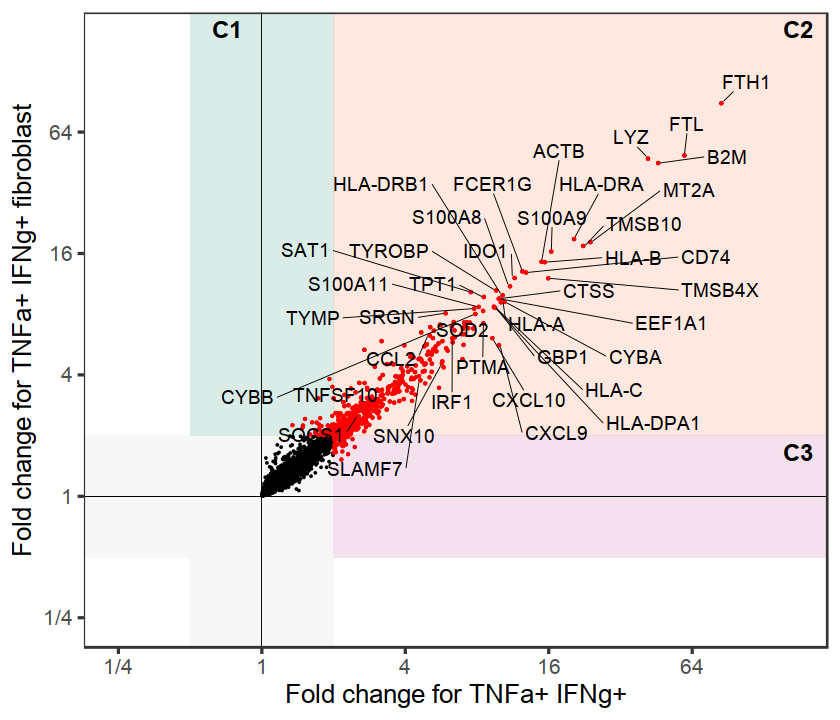

In [112]:
dat$signif <- abs(dat$fc_tnf_ifg) > log2(2) | abs(dat$fc_tnf_ifg_fib) > log2(2)
table(dat$signif)

temp <- dat[which(dat$fc_tnf_ifg_fib > log2(8) & abs(dat$fc_tnf_ifg) < log2(8)),]
gene_plot <- as.character(temp$Gene)
length(gene_plot)
temp <- dat[which(dat$fc_tnf_ifg > log2(8)),]
gene_plot <- c(gene_plot, as.character(temp$Gene))
length(gene_plot)
gene_plot <- c(gene_plot, c("CCL2", "IRF1", "TNFSF10", "SLAMF7", "SOCS1", "SNX10", "HLA-DRB1", "CD74"))
gene_plot <- unique(gene_plot)
length(gene_plot)

options(repr.plot.width = 7, repr.plot.height = 6)

# dat %>% lmFit(signif) %>%
dat %>%
ggplot(aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib)) +
annotate(
  geom = "rect",
  fill = "grey97",
  xmin = -Inf, xmax = Inf, ymin = -log2(2), ymax = log2(2)
) +
annotate(
  geom = "rect",
  fill = "grey97",
  ymin = -Inf, ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[1],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
annotate(
  geom = "rect",
  fill = cat_colors[2],
  alpha = cat_alpha, color = NA,
  ymin = log2(2), ymax = Inf, xmin = log2(2), xmax = Inf
) +
annotate(
  geom = "rect",
  fill = cat_colors[4],
  alpha = cat_alpha, color = NA,
  ymin = -log2(2), ymax = log2(2), xmin = log2(2), xmax = Inf
) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[3],
#   alpha = cat_alpha, color = NA,
#   ymin = -Inf, ymax = -log2(2), xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[5],
#   alpha = cat_alpha, color = NA,
#   ymin = -log2(2), ymax = log2(2), xmin = -Inf, xmax = -log2(2)
# ) +
annotate(
  geom = "text", color = "black", label = "C1",
  y = Inf, x = -log(2), hjust = 0, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C2",
  y = Inf, x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C3",
  y = log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 5, fontface = "bold"
) +
# annotate(
#   geom = "text", color = "black", label = "C4",
#   y = -log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
# ) +
# annotate(
#   geom = "text", color = "black", label = "C5",
#   y = log2(2), x = -Inf, hjust = -0.9, vjust = 1.5, size = 6, fontface = "bold"
# ) +
geom_point(
  data = dat,
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib),
  size = 0.01
) +
geom_point(
  data = subset(dat, fc_tnf_ifg_fib > log2(2) & abs(fc_tnf_ifg) < log2(4)),
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_point(
  data = subset(dat, (fc_tnf_ifg) > log2(2)),
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
# geom_text_repel(
#   data =subset(dat, (fc_tnf_ifg_fib) > log2(2) & abs(fc_tnf_ifg) < log2(2)),
#   mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.4, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
# geom_text_repel(
#   data =subset(dat, fc_tnf_ifg > log2(4)),
#   mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
#   box.padding = unit(0.2, "lines"),
#   point.padding = unit(0.2, "lines"),
#   segment.size = 0.2
# ) +
geom_point(
  data = subset(dat, abs(fc_tnf_ifg_fib) > 2 & abs(fc_tnf_ifg) > 2),
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib),
  color = "red", size = 0.2
) +
geom_text_repel(
  data =dat[which(dat$Gene %in% gene_plot),],  # "FCN1", "SPP1"
  mapping = aes(x = fc_tnf_ifg, y = fc_tnf_ifg_fib, label = Gene),
  box.padding = unit(0.4, "lines"),
  point.padding = unit(0.2, "lines"),
  segment.size = 0.2
) +
scale_color_manual(values = c("grey70", "black")) +
scale_y_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(6)) +
scale_x_continuous(expand = c(0.2, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(4)) +
theme(legend.position = "none") +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
labs(x = "Fold change for TNFa+ IFNg+", y = "Fold change for TNFa+ IFNg+ fibroblast"
#      title = "Human blood-derived macropahge phenotypes"
    ) +
theme_bw(base_size = 15) +
theme(
#     legend.position = "none",
    axis.line = element_blank(),
#     axis.text = element_blank(),
#     axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15)
  ) 
                   
ggsave(file = paste("linear_model_plot1", ".pdf", sep = ""), width = 7, height = 6, dpi = 300)

In [25]:
dat_tnf_fib <- topTable(fit2, coef = "stimTNFa+ fibro+", sort.by = "t", number = 60)
dat_tnf_ifg_fib <- topTable(fit2, coef = "stimTNFa+ IFNg+ fibro+", sort.by = "t", number = 60)
dat_tnf_ifg <- topTable(fit2, coef = "stimTNFa+ IFNg+", sort.by = "t", number = 60)
dat_tnf <- topTable(fit2, coef = "stimTNFa+", sort.by = "t", number = 60)
dat_il4 <- topTable(fit2, coef = "stimIL4+", sort.by = "t", number = 60)
dat_ifg_fib <- topTable(fit2, coef = "stimIFNg+ fibro+", sort.by = "t", number = 60)
dat_ifg <- topTable(fit2, coef = "stimIFNg+", sort.by = "t", number = 60)
dat_ifb <- topTable(fit2, coef = "stimIFNb+", sort.by = "t", number = 60)

g1 <- setdiff(dat_tnf_ifg$ID, dat_tnf_fib$ID)
g2 <- setdiff(dat_tnf_fib$ID, dat_tnf_ifg$ID)
g3 <- setdiff(dat_ifb$ID, dat_tnf_ifg$ID)
g4 <- setdiff(dat_il4$ID, dat_tnf_ifg$ID)
g_all <- c(g1, g2, g3, g4)
g_all <- unique(g_all)
# g_all

g_all <- c("MT1G", "SOD2", "CCL2", "SAT1", "TNFSF13B", "CXCL9", "CXCL10", "IDO1", "GBP1", "IRF1", 
           "STAT1", "LAPTM5", "CSTB", "HSP90AA1", "HLA-E",
                   "MARCKS", "CYP1B1", "CD163", "GPNMB", "CXCL1", "CXCL3", "CXCL5", "CXCL8", "MRC1",
                   "HIF1A", "MMP9", "CLEC4A", "TGFBI", "FCN1", "EREG",  "CREM", 
                   "PLAUR", "HBEGF", "NAMPT", "IL1B")
g_all <- unique(g_all)

dat_plot <- dat2[which(dat2$Gene %in% g_all),]
dat_plot[1:4,]

dat_1 <- dat_plot[, c(1:9)]
dat_1 <- melt(dat_1)
dat_1$variable <- substring(dat_1$variable, 6)
colnames(dat_1)[3] <- "FC"

dat_2 <- dat_plot[, c(1,29:36)]
dat_2 <- melt(dat_2)
dat_2$variable <- substring(dat_2$variable, 3)
colnames(dat_2)[3] <- "T"

# all(dat_1$variable == dat_2$variable)
# all(dat_1$Gene == dat_2$Gene)

dat_fc_t <- dat_1
dat_fc_t$T <- dat_2$T
dat_fc_t[1:4,]
dim(dat_fc_t)

,Gene,lgfc_tnf_fib,lgfc_tnf_ifg_fib,lgfc_tnf_ifg,lgfc_tnf,lgfc_il4,lgfc_ifg_fib,lgfc_ifg,lgfc_ifb,lgfc_control,...,t_tnf_fib,t_tnf_ifg_fib,t_tnf_ifg,t_tnf,t_il4,t_ifg_fib,t_ifg,t_ifb,t_control,signif
947,CCL2,1.9756603,3.8259173,3.3161771,2.2287835,1.6862712,3.8216676,3.1791669,2.9119030,2.5885967,...,57.76348,101.45129,103.63461,49.01517,43.96150,100.69192,89.36945,74.34096,85.59457,TRUE
994,CD163,0.3705796,0.3196027,0.2982086,0.6789530,0.4647631,0.5353013,0.5688360,1.1753598,1.0599369,...,18.81331,14.71550,16.18191,25.92656,21.03872,24.48965,27.76549,52.10323,60.85614,FALSE
1205,CLEC4A,1.7810923,0.9019304,0.9114457,1.2757818,2.7339066,0.9516990,0.9581726,1.4333135,1.4324656,...,100.95869,46.36723,55.22225,54.39453,138.17991,48.61357,52.21986,70.94285,91.82950,TRUE
1363,CREM,1.0119609,0.3802144,0.1908158,0.3053114,0.5321229,0.3574176,0.1591782,0.3370508,0.3488075,...,67.42719,22.97633,13.58976,15.30157,31.61456,21.46089,10.19740,19.60996,26.28439,TRUE


Using Gene as id variables
Using Gene as id variables


Gene,variable,FC,T
CCL2,tnf_fib,1.9756603,57.76348
CD163,tnf_fib,0.3705796,18.81331
CLEC4A,tnf_fib,1.7810923,100.95869
CREM,tnf_fib,1.0119609,67.42719


[1] 280   4

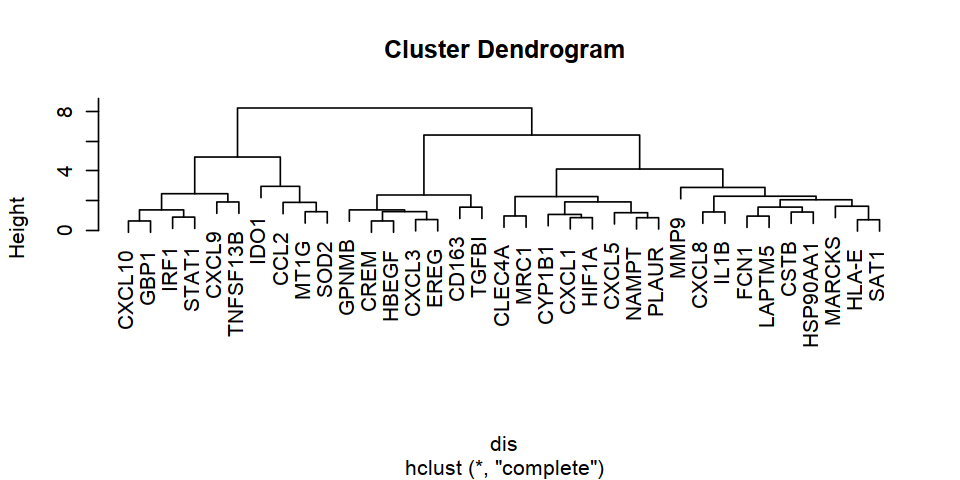

In [28]:
options(repr.plot.width = 8, repr.plot.height = 4)
test <- dat_plot[,1:9]
rownames(test) <- test[, 1]
test <- test[, -1]
dis <- dist(test, method = 'euclidean')
hcl <- hclust(dis)
plot(hcl)


null device 
          1

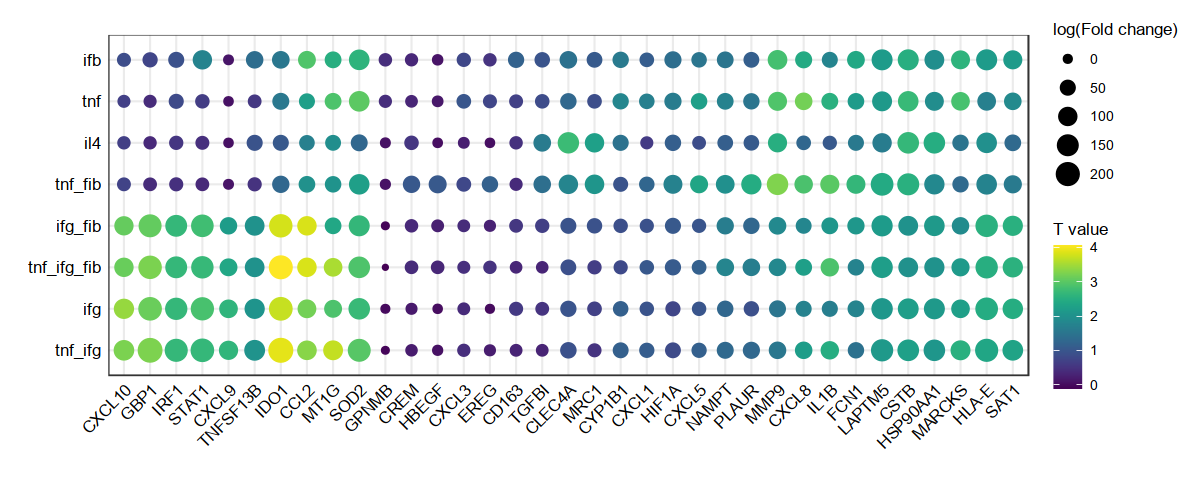

In [31]:
dat_fc_t$Gene <- factor(dat_fc_t$Gene, levels = rownames(test)[hcl$order])
dat_fc_t$variable <- factor(dat_fc_t$variable, levels = c("tnf_ifg", "ifg", "tnf_ifg_fib", "ifg_fib",
                                                         "tnf_fib", "il4", "tnf", "ifb"))


options(repr.plot.height = 4, repr.plot.width = 10)
ggplot(dat_fc_t, aes(Gene, variable)) +
  geom_point(aes(size = T, colour=FC)) + 
  ggtitle("") +
  scale_color_viridis() +
  theme_bw(base_size = 10) +
  labs(x = "", y = "", size = "log(Fold change)", colour = "T value") +
  theme(axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
        axis.text.y = element_text(size = 10, color = "black"),
        title = element_text(size=10),
#         panel.grid = element_blank(),
        axis.ticks = element_blank()
       )

dev.off()


In [32]:
# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

,t_tnf_fib,t_tnf_ifg_fib,t_tnf_ifg,t_tnf,t_il4,t_ifg_fib,t_ifg,t_ifb
CCL2,57.76348,101.45129,103.63461,49.01517,43.96150,100.69192,89.36945,74.34096
CD163,18.81331,14.71550,16.18191,25.92656,21.03872,24.48965,27.76549,52.10323
CLEC4A,100.95869,46.36723,55.22225,54.39453,138.17991,48.61357,52.21986,70.94285
CREM,67.42719,22.97633,13.58976,15.30157,31.61456,21.46089,10.19740,19.60996


png 
  2

,lgfc_tnf_fib,lgfc_tnf_ifg_fib,lgfc_tnf_ifg,lgfc_tnf,lgfc_il4,lgfc_ifg_fib,lgfc_ifg,lgfc_ifb
CCL2,1.9756603,3.8259173,3.3161771,2.2287835,1.6862712,3.8216676,3.1791669,2.9119030
CD163,0.3705796,0.3196027,0.2982086,0.6789530,0.4647631,0.5353013,0.5688360,1.1753598
CLEC4A,1.7810923,0.9019304,0.9114457,1.2757818,2.7339066,0.9516990,0.9581726,1.4333135
CREM,1.0119609,0.3802144,0.1908158,0.3053114,0.5321229,0.3574176,0.1591782,0.3370508


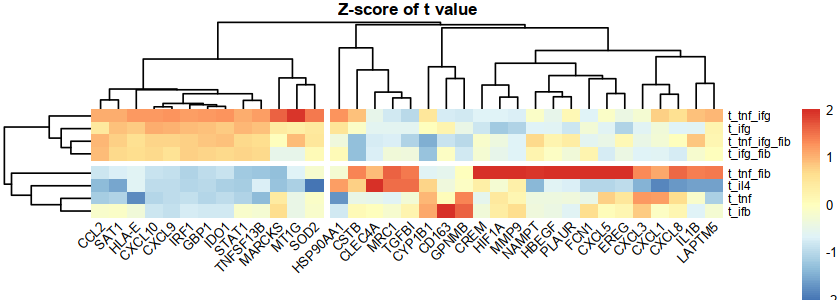

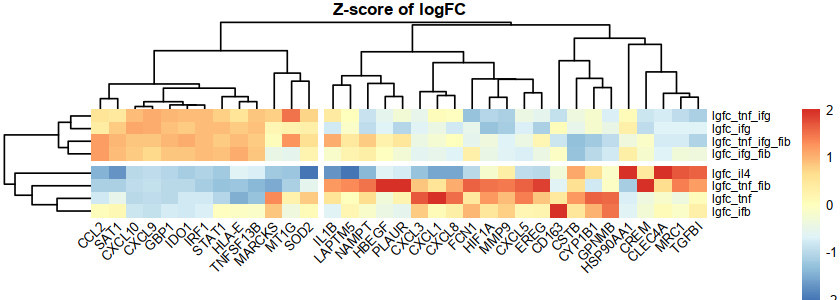

In [33]:
library(pheatmap)
g_all <- c(g1, g2, g3, g4)
g_all <- unique(g_all)
# g_all

g_all <- c("MT1G", "SOD2", "CCL2", "SAT1", "TNFSF13B", "CXCL9", "CXCL10", "IDO1", "GBP1", "IRF1", 
           "STAT1", "LAPTM5", "CSTB", "HSP90AA1", "HLA-E",
                   "MARCKS", "CYP1B1", "CD163", "GPNMB", "CXCL1", "CXCL3", "CXCL5", "CXCL8", "MRC1",
                   "HIF1A", "MMP9", "CLEC4A", "TGFBI", "FCN1", "EREG",  "CREM", 
                   "PLAUR", "HBEGF", "NAMPT", "IL1B")
g_all <- unique(g_all)

dat_plot <- dat2[which(dat2$Gene %in% g_all),]
dat_heat <- dat_plot[, c(1, 29:36)] # t value

rownames(dat_heat) <- dat_heat$Gene
dat_heat <- dat_heat[, -1]
dat_heat[1:4,]

scale_rows <- function(x) t(scale(t(x)))
dat_heat_scale <- scale_rows(dat_heat) # Z-score
dat_heat_scale[dat_heat_scale > 2] <- 2
dat_heat_scale[dat_heat_scale < -2] <- -2


options(repr.plot.width = 7, repr.plot.height = 2.5)
x <- pheatmap(
  mat = t(dat_heat_scale),
  border_color = NA,
#   breaks  = mat_breaks,
#   color  = magma(50),
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  cutree_rows = 2,
  cutree_cols = 2,
  main = "Z-score of t value",
  fontsize = 7.5,
  fontsize_row = 7
#   scale = "none"
)
save_pheatmap_pdf <- function(x, filename, width=7, height=2.5) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
save_pheatmap_pdf(x, "heatmap_linearmodle.pdf")




dat_plot <- dat2[which(dat2$Gene %in% g_all),]
dat_heat <- dat_plot[, c(1:9)] # t value

rownames(dat_heat) <- dat_heat$Gene
dat_heat <- dat_heat[, -1]
dat_heat[1:4,]

scale_rows <- function(x) t(scale(t(x)))
dat_heat_scale <- scale_rows(dat_heat) # Z-score
dat_heat_scale[dat_heat_scale > 2] <- 2
dat_heat_scale[dat_heat_scale < -2] <- -2


x <- pheatmap(
  mat = t(dat_heat_scale),
  border_color = NA,
#   breaks  = mat_breaks,
#   color  = magma(50),
  show_rownames = TRUE,
  show_colnames = TRUE,
  cluster_rows = TRUE,
  cluster_cols = TRUE,
  cutree_rows = 2,
  cutree_cols = 2,
  main = "Z-score of logFC",
  fontsize = 7.5,
  fontsize_row = 7
#   scale = "none"
)



In [35]:
# Save results

dat_tnf_fib <- topTable(fit2, coef = "stimTNFa+ fibro+", sort.by = "t", number = 60)
dat_tnf_ifg_fib <- topTable(fit2, coef = "stimTNFa+ IFNg+ fibro+", sort.by = "t", number = 60)
dat_tnf_ifg <- topTable(fit2, coef = "stimTNFa+ IFNg+", sort.by = "t", number = 60)
dat_tnf <- topTable(fit2, coef = "stimTNFa+", sort.by = "t", number = 60)
dat_il4 <- topTable(fit2, coef = "stimIL4+", sort.by = "t", number = 60)
dat_ifg_fib <- topTable(fit2, coef = "stimIFNg+ fibro+", sort.by = "t", number = 60)
dat_ifg <- topTable(fit2, coef = "stimIFNg+", sort.by = "t", number = 60)
dat_ifb <- topTable(fit2, coef = "stimIFNb+", sort.by = "t", number = 60)
